# CPS3: _Simulation of the Brownian motion_

In [118]:
import numpy as np
import matplotlib.pyplot as plt

In [448]:
T = 2.0

## Question 1

### 1.(b)

For simulating trajectories of the Brownian motion, we will use a forwards simulation algorithm.

To greatly speed up the computation of these trajectories, we will use the `numba` library, which is included in the Anaconda distribution; elsewise, it can be installed with `pip install numba`.

In [132]:
@numba.njit("int32,float64")
def brownian(n, T):
    dt = T/n
    Zi = dt**0.5*np.random.randn(n)
    return np.cumsum(Zi)

In [158]:
n = 500
tar = np.linspace(0, T, n, endpoint=True)
traj = brownian(n, T)

print(traj.shape)

(500,)


Text(0, 0.5, '$W_t$')

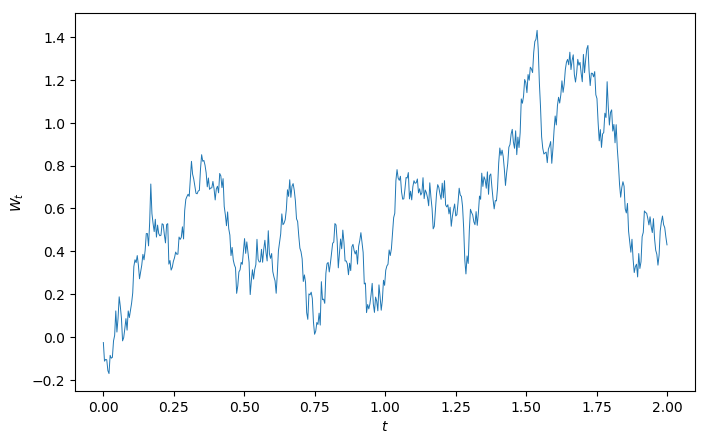

In [159]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(tar, traj, linewidth=0.7)
plt.xlabel("$t$")
plt.ylabel("$W_t$")

In [304]:
def quadratures(traj):
    # Finite difference
    dWn = traj[:-1]-traj[1:]

    In = np.sum(traj[1:]*dWn)
    Jn = np.sum(traj[:-1]*dWn)
    Kn = np.sum(0.5*(traj[1:]+traj[:-1])*dWn)
    return np.array((In, Jn, Kn))

In [305]:
quadratures(traj)

array([-1.0254357 ,  0.08239097, -0.47152236])

Now, we compute all three approximations of $\int_0^T W_s\,\mathrm{d}W_s$ for $N=1000$ trajectories.

In [306]:
quadratures(brownian(n, T))

array([-1.60521979,  1.56320097, -0.02100941])

In [405]:
def quad_samples(n, T):
    M = 1000
    samples = []
    for _ in range(M):
        traj = brownian(n, T)
        WT = traj[-1]
        samples.append(0.5*WT**2 - quadratures(traj))

    samples = np.stack(samples)
    return samples

In [406]:
samples = quad_samples(n, T)
samples

array([[ 1.77136895,  0.55741532,  1.16439213],
       [ 0.58332217, -0.52503663,  0.02914277],
       [ 4.15791109,  2.15521529,  3.15656319],
       ...,
       [ 0.82425228, -0.74634916,  0.03895156],
       [ 2.18941369,  0.88218418,  1.53579894],
       [ 0.99214941, -1.6209908 , -0.31442069]])

### 1.(b)

In [410]:
samples = quad_samples(n, T)
means = np.mean(samples, axis=0)
means

array([2.8999035 , 1.03174425, 1.96582388])

Each computation of the formulas returns a different set of values for their empirical means: this is normal, because 
the stochastic integral $\int_0^T W_s\,\mathrm{d}W_s$ **is a random variable**.

The means of the different approximation formulas do not give the same result, as you'd expect from for instance the Riemann/Stieltjes integral.

### 1.(c)

In [411]:
means = []
variances = []
for n in range(10, 21):
    samples = quad_samples(n, T)
    means.append(np.mean(samples, axis=0))
    variances.append(np.var(samples, axis=0, ddof=1))
means = np.stack(means)
variances = np.stack(variances)
sigmas = np.sqrt(variances)

The 95% confidence interval has half-width given by
$$
    1.96\frac{\sigma_M}{\sqrt{M}}
$$

Text(0.5, 0.98, 'Performance of different estimators of the stochastic integral $\\int_0^T W_s\\,\\mathrm{d}W_s$')

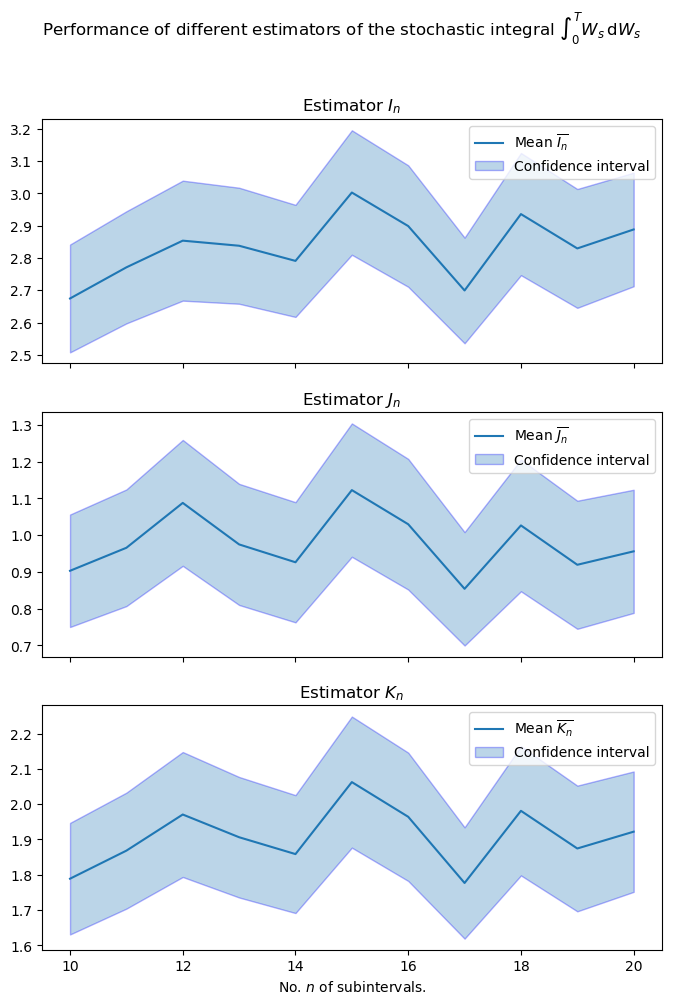

In [412]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,11), dpi=100)
indices = np.arange(10, 21)

fill_opts = {
    "label": "Confidence interval",
    "alpha": 0.3,
    "edgecolor": "b"
}

quantity_names = ["I_n", "J_n", "K_n"]

for i, ax in enumerate(axes):
    est_name = quantity_names[i]
    ax.plot(indices, means[:,i], label=r"Mean $\overline{"+est_name+"}$")
    ax.fill_between(
        indices,
        means[:,i]-1.96*sigmas[:,i]/M**0.5,
        means[:,i]+1.96*sigmas[:,i]/M**0.5,
        **fill_opts
    )
    ax.legend()
    ax.set_title("Estimator $%s$" % est_name)

ax.set_xlabel("No. $n$ of subintervals.")
fig.suptitle(r"Performance of different estimators of the stochastic integral $\int_0^T W_s\,\mathrm{d}W_s$")

## Question 2

We are now computing approximations for the stochastic integral
$$
    \int_0^T e^s \,\mathrm{d}W_s
$$

We define a function to compute the formulas for $A_n$, $B_n$, and $C_n$.

In [413]:
def abc_quad(traj, T):
    n = traj.shape[0]
    dt = T/n
    dWn = traj[:-1] - traj[1:]
    ti = dt*np.arange(0, n)
    an = np.sum(ti[1:]*dWn)
    bn = np.sum(ti[:-1]*dWn)
    cn = np.sum(0.5*(ti[1:]+ti[:-1])*dWn)
    return np.array((an, bn, cn))

Now, we can compute the $N = 1000$ samples.

In [414]:
def abc_quad_samples(n, T, M = 1000):
    samples = []
    for _ in range(M):
        traj = brownian(n, T)
        WT = traj[-1]
        samples.append(0.5*WT**2 - abc_quad(traj, T))

    samples = np.stack(samples)
    return samples

In [467]:
means = np.zeros((11,3))
sigmas = np.zeros((11,3))
for n in range(10, 21):
    samples = abc_quad_samples(n, T)
    means[n-10] = np.mean(samples, axis=0)
    sigmas[n-10] = np.std(samples, axis=0, ddof=1)

In [468]:
means

array([[0.88072135, 0.88986193, 0.88529164],
       [0.99741295, 0.99736452, 0.99738874],
       [1.03847016, 1.04026599, 1.03936808],
       [0.88549533, 0.89455509, 0.89002521],
       [0.99201242, 0.98628166, 0.98914704],
       [0.97601077, 0.97981296, 0.97791187],
       [1.03099022, 1.03090694, 1.03094858],
       [1.02351674, 1.02824528, 1.02588101],
       [0.98928854, 0.98909374, 0.98919114],
       [0.82825048, 0.83432717, 0.83128882],
       [1.00019014, 1.00293949, 1.00156482]])

The results for this set of approximations are actually pretty close to each other. This could be expected: this is a stochastic integral, but the integrand is a deterministic function $s\longmapsto e^s$.

Text(0.5, 0.98, 'Performance of different estimators of the stochastic integral $\\int_0^T e^s\\,\\mathrm{d}W_s$')

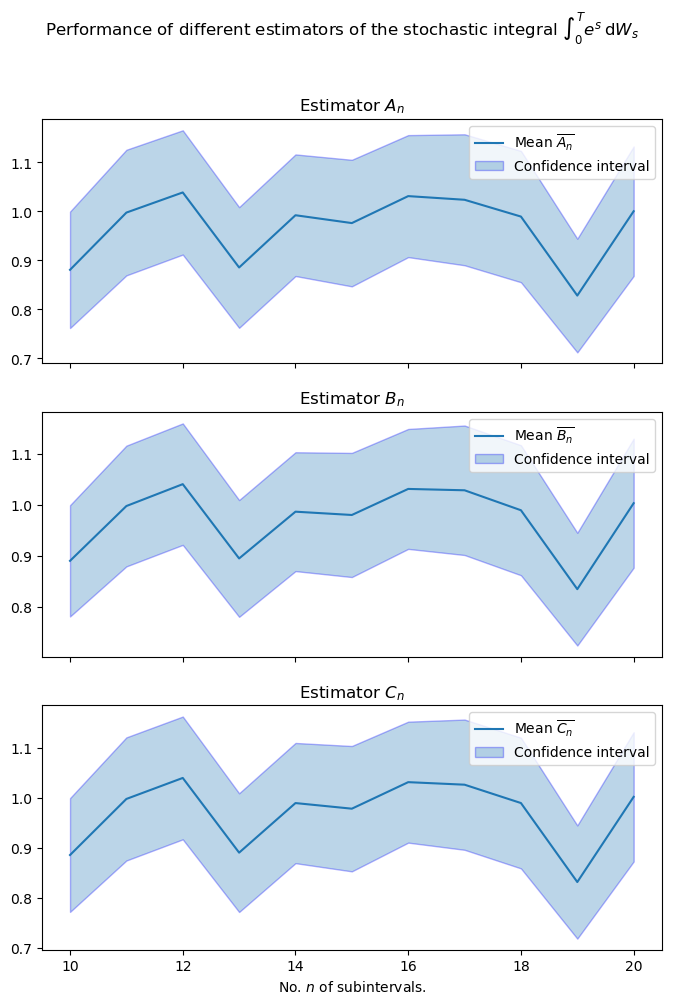

In [469]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,11), dpi=100)
indices = np.arange(10, 21)

fill_opts = {
    "label": "Confidence interval",
    "alpha": 0.3,
    "edgecolor": "b"
}

quantity_names = ["A_n", "B_n", "C_n"]

for i, ax in enumerate(axes):
    est_name = quantity_names[i]
    ax.plot(indices, means[:,i], label=r"Mean $\overline{"+est_name+"}$")
    ax.fill_between(
        indices,
        means[:,i]-1.96*sigmas[:,i]/M**0.5,
        means[:,i]+1.96*sigmas[:,i]/M**0.5,
        **fill_opts
    )
    ax.legend()
    ax.set_title("Estimator $%s$" % est_name)

ax.set_xlabel("No. $n$ of subintervals.")
fig.suptitle(r"Performance of different estimators of the stochastic integral $\int_0^T e^s\,\mathrm{d}W_s$")

The confidence interval is somewhat tighter than for the previous stochastic integral. Again, this might be due to the integrand being a deterministic function.

## Question 3

The goal here is to approximate the integral
$$
    A = \int_0^T \sin(W_s)\,\mathrm{d}s
$$
which is still a random variable.

We'll be using `numba` to speed up the computation of $A_n$ and its samples (it comes with the Anaconda distribution).

In [462]:
import numba

In [455]:
@numba.njit("float64(float64[:],float64)")
def compute_A(traj, T):
    n = traj.shape[0]
    dt = T/n
    WT = traj[-1]
    
    return np.sin(WT) + 1/(2*n)*np.sum(np.sin(traj[1:]))

In [456]:
@numba.njit("float64[:](int64,float64)")
def A_samples(n, T):
    M=1000
    res = np.zeros((M,))
    for _ in range(M):
        traj = brownian(n, T)
        res[i] = compute_A(traj, T)
    return res

Now, we can compute the samples, their means and standard deviations.

In [459]:
Nmin = 10
Nmax = 201
means = np.zeros((Nmax-Nmin,))
sigmas = np.zeros((Nmax-Nmin,))
for n in range(Nmin, Nmax):
    samples = A_samples(n, T)
    means[n-Nmin] = np.mean(samples)
    sigmas[n-Nmin] = np.std(samples, ddof=1)

Text(0.5, 1.0, 'Mean and confidence interval for $A_n$')

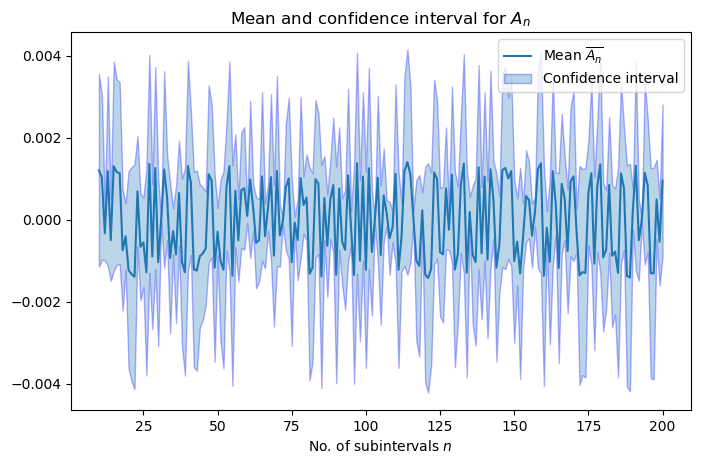

In [461]:
plt.figure(figsize=(8,5), dpi=100)
ax = plt.axes()
indices = np.arange(Nmin, Nmax)

fill_opts = {
    "label": "Confidence interval",
    "alpha": 0.3,
    "edgecolor": "b"
}

ax.plot(indices, means, label=r"Mean $\overline{A_n}$")
ax.fill_between(
    indices,
    means-1.96*sigmas/M**0.5,
    means+1.96*sigmas/M**0.5,
    **fill_opts
)
ax.set_xlabel("No. of subintervals $n$")
ax.legend()
ax.set_title("Mean and confidence interval for $A_n$")

The integral $A_n$'s value oscillates around $0$ as $n$ changes. This is coherent, since one can show that
$$
    \mathbb E[A] = 0.
$$

Indeed, we have
$$\mathbb E[A]= \int_0^T \mathbb E[\sin W_s]\,\mathrm ds
$$
from Fubini's theorem, and it holds that
$$
    \mathbb E[\sin W_s] = \Im \mathbb E[e^{iW_s}] = \Im \mathbb E[e^{i\sqrt s G}] = \Im(e^{-\frac12 s}) = 0$$
where $G\sim \mathcal N(0,1)$ is introduced so that $W_s\sim \sqrt s G$.

Thus,
$$
    \mathbb E[A] = 0.
$$